## Uncertainty in Explanations via Model Perturbation (Vision)

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import cv2
import pickle

In [2]:
#import sys
#sys.path.append('./xplique/')
from xplique.attributions import (Lime, Saliency, GradientInput, IntegratedGradients, 
                                  SmoothGrad, SquareGrad, VarGrad, Occlusion, Rise,
                                  KernelShap, DeconvNet, GuidedBackprop)

In [3]:
# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
x_train = gray2rgb(x_train)
x_test = gray2rgb(x_test)

In [4]:
# Whether to train a model or load a pretrained one
train_model = False
model_path = './models/cnn_mnist.h5' # with relu
#model_path = './models/cnn_mnist_no_relu.h5'

In [5]:
if train_model:
    # Build and train a simple CNN
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)), # RGB
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    """

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=2, batch_size=64, validation_split=0.25)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)
# XAI methods require removal of Softmax
model.layers[-1].activation = tf.keras.activations.linear

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

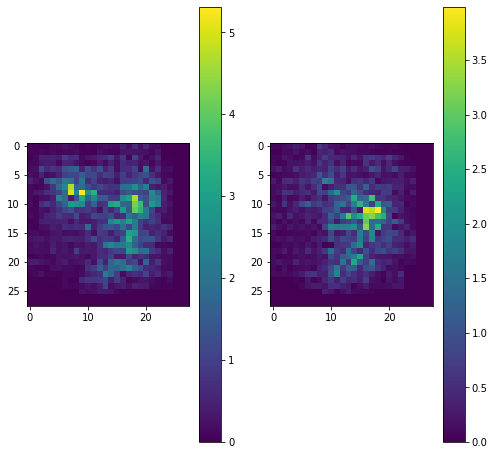

In [98]:
# Explain sample prediction
sample_index = 0
sample_image, sample_label = x_test[sample_index], y_test[sample_index]
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = np.expand_dims(sample_label, axis=0)

perturbed_model = tf.keras.models.load_model(model_path)
perturbed_model.layers[-1].activation = tf.keras.activations.linear # remove Softmax
weights, bias = perturbed_model.layers[-1].get_weights()
weights += np.random.normal(0, 1e-3, weights.shape)
perturbed_model.layers[-1].set_weights([weights, bias])

explainer = Saliency(model)
explainer_pert = Saliency(perturbed_model)
orig_exp = explainer.explain(sample_image, sample_label)
pert_exp = explainer_pert.explain(sample_image, sample_label)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(orig_exp[0])
plt.colorbar()
plt.subplot(122)
plt.imshow(pert_exp[0])
plt.colorbar()

### Analytical vs empirical (multiple methods, multiple variances)

In [7]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # silence tf-function warnings
xai_methods  = {'Saliency': lambda model: Saliency(model),
                'GradientInput': lambda model: GradientInput(model),
                'IntegratedGradients': lambda model: IntegratedGradients(model, steps=20, batch_size=1),
                'GuidedBackprop': lambda model: GuidedBackprop(model),
                'Occlusion': lambda model: Occlusion(model, batch_size=1), # with default patch_size and patch_stride
                #'Lime': lambda model: Lime(model, nb_samples = 20, batch_size=1),
                #'SquareGrad': lambda model: SquareGrad(model, nb_samples=20, batch_size=1),
                #'VarGrad': lambda model: VarGrad(model, nb_samples=20, batch_size=1),
                #'DeconvNet': lambda model: DeconvNet(model)
               }

In [8]:
#stds = [0.2, 0.3, 0.4, 0.5] # std. deviations
stds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
num_perturbations = 10 # for empirical cov.
dx = 1e-3 # differential for ana. cov.
h = w = x_train[0].shape[0] # (28, 28, 3)
m = np.product(np.shape(x_train[0])[:-1]) # for simplicity, treat RGB channels as one point/step
n = model.layers[-1].weights[0].shape[0] # number of weights in the final Dense layer (without bias) per class

In [13]:
sample_indexes = [11] # samples 3 and 10 yields NaNs
#results, cov_mats, jacobi_mats, empirical_exps, unperturbed_exps = {}, {}, {}, {}, {}

for sample_index in sample_indexes:
    # Read sample image and label
    sample_image, sample_label = x_test[sample_index], y_test[sample_index]
    sample_label = np.expand_dims(sample_label, axis=[0,1])

    # Store results for plotting
    results[sample_index] = {}
    cov_mats[sample_index] = {}
    jacobi_mats[sample_index] = {}
    empirical_exps[sample_index] = {}
    unperturbed_exps[sample_index] = {}
    
    print('\n*********')
    print('Sample ' + str(sample_index))
    for name, constructor in xai_methods.items():
        print('\n' + name)
        results[sample_index][name]  = {'analytical': [], 'empirical': []}
        cov_mats[sample_index][name] = {'analytical': [], 'empirical': []}
        empirical_exps[sample_index][name] = {}

        # Get explanation in unperturbed model
        explainer = constructor(model) # instantiate explainer with default params
        explanation = explainer(np.expand_dims(sample_image, axis=0), sample_label)[0]
        unperturbed_exps[sample_index][name] = explanation.numpy().flatten()
        
        # Norm of explanation (for normalization of total variance)
        norm_exp_squared = np.linalg.norm(explanation)**2
        
        # Precompute Jacobian (stays fixed for every std)
        derivative_e_x = np.zeros((m, n))
        # For every pixel perturbation, we get a new column in the Jacobian
        for i in range(n):
            # Perturb current weight in the model
            perturbed_model = tf.keras.models.load_model(model_path)
            perturbed_model.layers[-1].activation = tf.keras.activations.linear # remove Softmax
            weights, bias = perturbed_model.layers[-1].get_weights()
            weights[i] += dx # add dx to all 10 weights at index i
            perturbed_model.layers[-1].set_weights([weights, bias])

            # Compute explanations for perturbed model
            explainer = constructor(perturbed_model)
            perturbed_exp = explainer(np.expand_dims(sample_image, axis=0), sample_label)[0]

            # Fill out the corresponding column in the jacobian
            derivative_2d = (perturbed_exp - explanation) / dx
            derivative_e_x[:, i] = derivative_2d.numpy().reshape(m, )
        jacobi_mats[sample_index][name] = derivative_e_x

        for std in stds:
            ### Analytical
            sigma_squared = std ** 2
            covariance_ana = sigma_squared * derivative_e_x @ derivative_e_x.T

            # Total variance is the trace of the cov. matrix
            total_var = np.trace(covariance_ana)/norm_exp_squared
            print("Analytical Variance (std = ", std, "):", total_var)
            results[sample_index][name]['analytical'].append(total_var)
            cov_mats[sample_index][name]['analytical'].append(covariance_ana)
            
            ### Empirical
            perturbed_explanations = []
            for _ in range(num_perturbations):
                # Add Gaussian noise to the model weights
                perturbed_model = tf.keras.models.load_model(model_path)
                perturbed_model.layers[-1].activation = tf.keras.activations.linear # remove Softmax
                weights, bias = perturbed_model.layers[-1].get_weights()
                weights += np.random.normal(0, std, weights.shape)
                perturbed_model.layers[-1].set_weights([weights, bias])

                # Generate explanation for perturbed model
                explainer = constructor(perturbed_model)
                perturbed_explanation = explainer.explain(np.expand_dims(sample_image, axis=0), sample_label)[0]
                perturbed_explanations.append(perturbed_explanation.numpy().flatten())

            # Stack explanations and compute covariance matrix
            explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
            covariance_emp = np.cov(explanation_matrix, rowvar=False)

            total_var = np.trace(covariance_emp)/norm_exp_squared
            print("Empirical Variance (std = ", std, "):", total_var)
            results[sample_index][name]['empirical'].append(total_var)
            cov_mats[sample_index][name]['empirical'].append(covariance_emp)
            
            # Store explanations for normality checks
            empirical_exps[sample_index][name][std] = np.stack(perturbed_explanations, axis=0)


*********
Sample 11

Saliency
Analytical Variance (std =  1e-06 ): 2.840502080147122e-10
Empirical Variance (std =  1e-06 ): 3.325464876093725e-11
Analytical Variance (std =  1e-05 ): 2.840502080147122e-08
Empirical Variance (std =  1e-05 ): 3.921284621306145e-09
Analytical Variance (std =  0.0001 ): 2.8405020801471217e-06
Empirical Variance (std =  0.0001 ): 2.515199566485401e-07
Analytical Variance (std =  0.001 ): 0.0002840502080147122
Empirical Variance (std =  0.001 ): 2.249137218243743e-05
Analytical Variance (std =  0.01 ): 0.028405020801471215
Empirical Variance (std =  0.01 ): 0.0029654391130703233
Analytical Variance (std =  0.1 ): 2.840502080147122
Empirical Variance (std =  0.1 ): 0.16557674796794422

GradientInput
Analytical Variance (std =  1e-06 ): 3.3565625964145194e-10
Empirical Variance (std =  1e-06 ): 3.668580248051381e-11
Analytical Variance (std =  1e-05 ): 3.356562596414519e-08
Empirical Variance (std =  1e-05 ): 3.5247868005482694e-09
Analytical Variance (std =

In [14]:
# Store results
experiments = {'results': results, 
               'cov_mats': cov_mats, 
               'jacobi_mats': jacobi_mats,
               'empirical_exps': empirical_exps, 
               'unperturbed_exps': unperturbed_exps}

with open('./experiments/experiments_weights_mnist_10ex_10pert_nosoft.pickle', 'wb') as handle:
    pickle.dump(experiments, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Load results
with open('./experiments/experiments_weights_mnist_9ex_10pert_nosoft.pickle', 'rb') as handle:
    experiments = pickle.load(handle)
results = experiments['results']
cov_mats = experiments['cov_mats']
jacobi_mats = experiments['jacobi_mats']
empirical_exps = experiments['empirical_exps']
unperturbed_exps = experiments['unperturbed_exps']

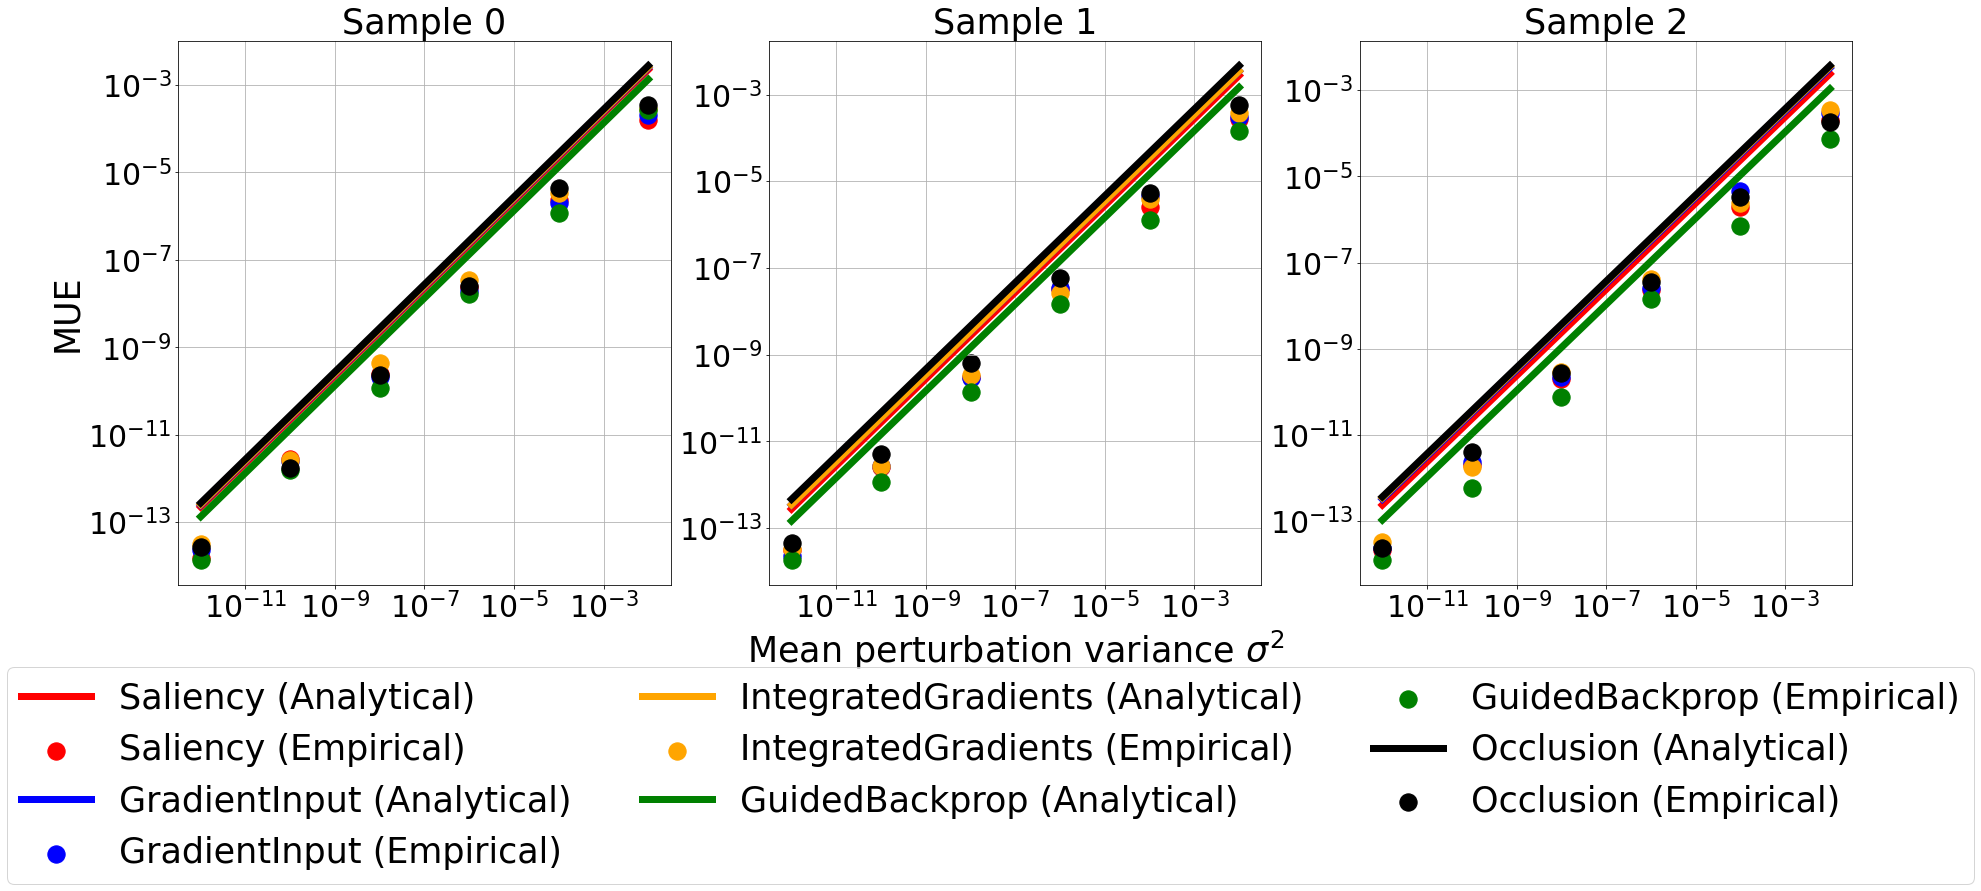

In [19]:
# Plot seveeral samples (Relu)
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fsize=35
fig = plt.figure(figsize=(30, 10))
for i, sample_id in enumerate([0,1,2]): 
    plt.subplot(1, 3, i+1)
    for (name, data), col in zip(experiments['results'][sample_id].items(), colors):
        plt.plot(stds*stds, np.asarray(data['analytical'])[:len(stds)]/m, label=f"{name} (Analytical)", c=col, lw=7)
        plt.scatter(stds*stds, np.asarray(data['empirical'])[:len(stds)]/m, marker='o', 
                    label=f"{name} (Empirical)", c=col, s=300)
    plt.title('Sample ' + str(sample_id), fontsize=fsize)
    if i==1: plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
    if i==0: plt.ylabel('MUE', fontsize=fsize)
    plt.xscale('log');plt.yscale('log')
    plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
    #plt.ylim([1e-12, 1e+5])
    if i==2: plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(-0.75, -0.12), ncol=3)
    plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_weights_mnist.png', bbox_inches='tight')

In [18]:
# Aggregate results
agg_results = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
sample_indexes = [0, 1, 2, 4, 5, 6, 7, 8, 9, 11]
for name in xai_methods.keys():
    for approach in ['analytical', 'empirical']:
        agg_sum = np.zeros(len(stds))
        for ex_ind in sample_indexes:
            sample_res = experiments['results'][ex_ind][name][approach]
            if np.isnan(sample_res).any():
                sample_res = np.finfo(float).eps * np.ones(len(stds))
            agg_sum += sample_res
        agg_results[name][approach] = agg_sum/len(sample_indexes)
#agg_results

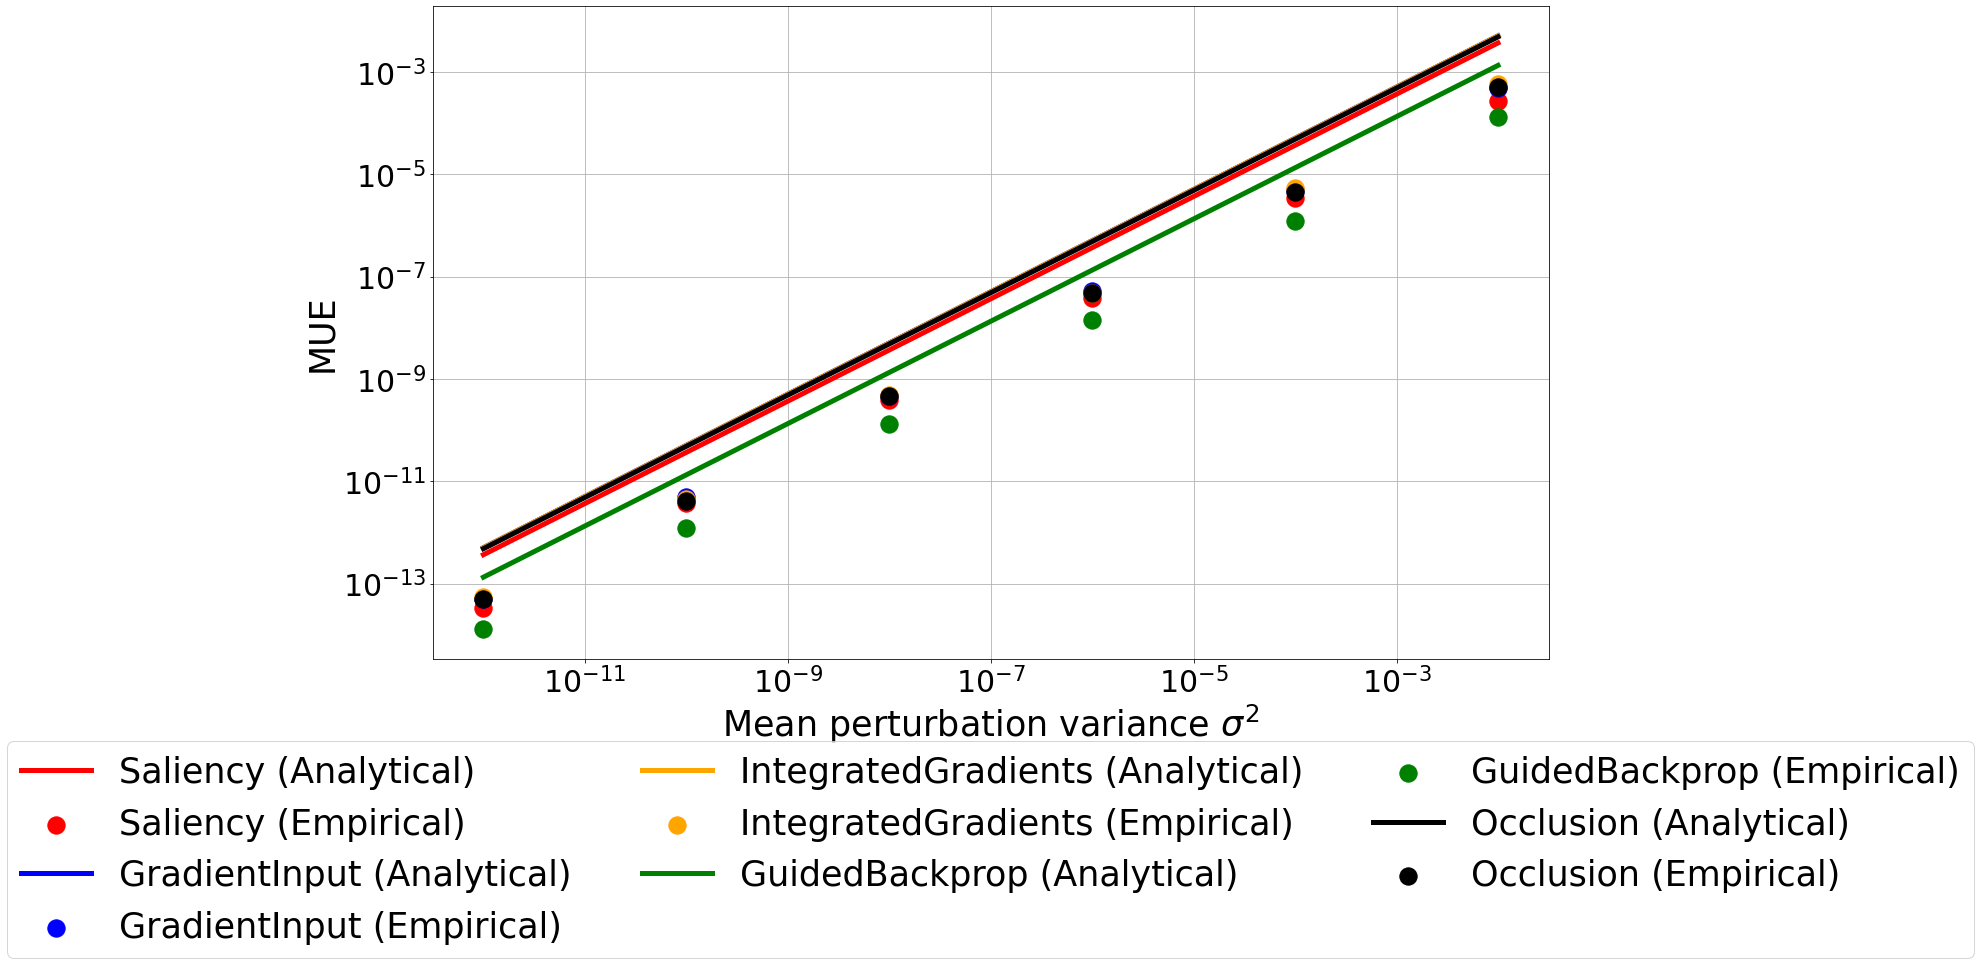

In [20]:
# Plot aggregations
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
stds = np.asarray([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fsize=35
fig = plt.figure(figsize=(20, 12))
for (name, data), col in zip(agg_results.items(), colors):
    plt.plot(stds*stds, np.asarray(data['analytical'])[:len(stds)]/m, label=f"{name} (Analytical)", c=col, lw=5)
    plt.scatter(stds*stds, np.asarray(data['empirical'])[:len(stds)]/m,  marker='o', 
                label=f"{name} (Empirical)", c=col, s=300)
plt.xlabel('Mean perturbation variance $\sigma^2$', fontsize=fsize)
plt.ylabel('MUE', fontsize=fsize)
plt.xscale('log');plt.yscale('log')
plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.grid(True)
plt.show()
fig.savefig('./figures/uncertainties_weights_mnist_agg.png', bbox_inches='tight')

In [ ]:
# Sample 0 ('7')
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14); plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14); plt.xscale('log')
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
std_ind = 0
fig, axes = plt.subplots(1, len(cov_mats), figsize=(5*len(cov_mats), 5))
fig.suptitle(f'Diagonals of Analytical Covariances, std={stds[std_ind]}', fontsize=30, y=1.02)

for i, (name, cmat) in enumerate(cov_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(cmat['analytical'][std_ind]).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

In [ ]:
std_ind = 0
fig, axes = plt.subplots(1, len(cov_mats), figsize=(5*len(cov_mats), 5))
fig.suptitle(f'Diagonals of Empirical Covariances, std={stds[std_ind]}', fontsize=30, y=1.02)

for i, (name, cmat) in enumerate(cov_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(cmat['empirical'][std_ind]).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

In [ ]:
# Create heatmaps for all methods and perturbation stds
# Note: it may take 2 mins to display
def plot_heatmaps(cov_mats, stds):
    num_methods = len(cov_mats)
    num_stds = len(stds)

    fig, axes = plt.subplots(num_methods, num_stds * 2, figsize=(4 * num_stds * 2, 4 * num_methods))
    fig.suptitle('Covariance Matrix Heatmaps (Analytical vs. Empirical)', fontsize=30, y=1.02)

    for i, (name, cov_data) in enumerate(cov_mats.items()):
        for j, std in enumerate(stds):
            # Analytical covariance matrix
            cov_ana = cov_data['analytical'][j]
            ax = axes[i, j * 2]
            sns.heatmap(cov_ana, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nAna, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

            # Empirical covariance matrix
            cov_emp = cov_data['empirical'][j]
            ax = axes[i, j * 2 + 1]
            sns.heatmap(cov_emp, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nEmp, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function to generate heatmaps
plot_heatmaps(cov_mats, stds)